# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        
        # Validate parameters conditions
        assert narms > 0, "Number of arms should be greater than 0"
        assert epsilon >= 0 and epsilon <= 1, "Epsilon should have values between 0 and 1"
        assert np.issubdtype(type(narms), np.integer), "Number of arms should be integer"
        assert np.issubdtype(type(epsilon), np.floating), "Epsilon should be a floating point"
        
        
        # Initialize attributes
        self.narms = narms
        self.epsilon = epsilon
        self.Q = np.full((narms,1), Q0)                # Set Q (avg. reward) to Q0 for round 0 for all arms
        self.i = np.zeros((narms,1))                   # Set i (selected arm) to 0 for round 0
        
        self.X = []                                    # List for storing the rewards for each round        
        self.X.append(0)                               # We initialize the reward with 0 for the round 0

        
    def get_random_argmax(self, x):                    # Returns the maximum argument with random choice in case of ties
        argmax = np.where( x == np.amax(x) )
        return (np.random.choice(argmax[0]) + 1)       # Returned arm should a number between 1 and self.narms
    
    
    def play(self, tround, context=None):
        
        # Validate parameter conditions
        assert tround > 0, "tround must be greater than 0"
        assert tround == self.Q.shape[1], "Can't play round %s. Next round for the arm should be number %s" % (tround, self.Q.shape[1])
        assert np.issubdtype(type(tround), np.integer), "tround must be integer number"
        
        
        # Exploit with probability 1-epsilon. Otherwise, Explore
        if  np.random.random() > self.epsilon:             
            return self.get_random_argmax(self.Q[:,tround-1])
        else:                                                           
            return np.random.randint(self.narms)
        
        
    def update(self, arm, reward, context=None):
        # Validate conditions
        assert arm >= 1 and arm <= self.narms, "Arm should be a number between 1 and %s (self.narms parameter)" % (self.narms)
        assert np.issubdtype(type(arm), np.integer), "Arm should be integer"
        assert np.issubdtype(type(reward), np.floating), "Reward should be float"
        
        
        # Add the reward to the corresponding arms' reward vector 
        self.X.append(reward)
        
        # Generate a row vector with the corresponding arm and then stack it at the bottom of "self.i" vector
        i_t = np.zeros((self.narms,1))
        i_t[arm-1] = 1
        self.i = np.hstack((self.i, i_t))
        
        # We update the Q(t-1) for the corresponding arm
        Qt = self.Q[:,[-1]]
        X_i = np.array(self.X[1:]).reshape(-1, 1)
        
        Qt[arm-1] = X_i.T @ self.i[arm-1, 1:]/(sum(self.i[arm-1, 1:]))
        self.Q = np.hstack((self.Q, Qt))
        
        return None
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        
        # Validate parameter conditions
        assert narms > 0, "Number of bandits' arms should be greater than 0"
        assert rho >= 0, "Rho should be a floating-point greater than 0"
        assert np.issubdtype(type(narms), np.integer), "Number of arms must be integer"
        assert np.issubdtype(type(rho), np.floating), "Rho must be floating point"
        
        
        # Initialize attributes
        self.narms = narms
        self.rho = rho
        self.Q = np.full((narms,1), Q0)                # Set Q (avg. reward) to Q0 for round 0 for all arms
        self.i = np.zeros((narms,1))                   # Set i (selected arm) to 0 for round 0 
        
        self.X = []                                    # List for storing the rewards for each round         
        self.X.append(0)                               # We initialize the reward with 0 for the round 0

    
    def get_random_argmax(self, x):                    # Returns the maximum argument with random choice in case of ties
        argmax = np.where( x == np.amax(x) )
        return (np.random.choice(argmax[0]) + 1)       # Returned arm should a number between 1 and self.narms
    
    
    def play(self, tround, context=None):
        
        # Validate parameter conditions
        assert tround > 0, "Number of tround must be greater than 0"
        assert tround == self.Q.shape[1], "Can't play round %s. Next round for the arm should be number %s" % (tround, self.Q.shape[1])
        assert np.issubdtype(type(tround), np.integer), "tround must be integer number"
        
        # We pick the arm with the best Q. In case of ties, we choose randomly
        return self.get_random_argmax(self.Q[:,tround-1])
        
        
    def update(self, arm, reward, context=None):
        
        # Validate parameter conditions
        assert arm >= 0 and arm <= self.narms, "Arm should be a number between 0 and %s (self.narms parameter)" % (self.narms)
        assert np.issubdtype(type(arm), np.integer), "Arm should be integer"
        assert np.issubdtype(type(reward), np.floating), "Reward should be float"
        
        
        # Add the reward to the corresponding arms' reward vector 
        self.X.append(reward)
        
        # Generate a row vector with the corresponding arm and then stack it at the end of the self.i vector
        i_t = np.zeros((self.narms,1))
        i_t[arm-1] = 1
        self.i = np.hstack((self.i, i_t))
                
        # We update the Q(t-1) for the corresponding arm
        Qt = self.Q[:,[-1]]
        X_i = np.array(self.X[1:]).reshape(-1, 1)
        
        avg_reward = X_i.T @ self.i[arm-1, 1:]/(sum(self.i[arm-1, 1:]))                                  # mean
        log_term = np.sqrt( self.rho * np.log(self.Q.shape[1] + 1) / (sum(self.i[arm-1, 1:]))  )         # sqrt(rho*log(t) / (N_samples))
        Qt[arm-1] = avg_reward + log_term
        self.Q = np.hstack((self.Q, Qt))
        return None
    
    

In [5]:
def read_TestData(filename):
    """
    Function for reading test data and extracting arms, rewards and contexts data
    
    Arguments
    =========
    filename : name of the test file where data resides
    
    Returns
    =========
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
    """
    arms = []
    rewards = []
    contexts = []

    with open(filename) as data:
        for rows in data:
            line = rows.split()
            arms.append(line[0])
            rewards.append(line[1])
            contexts.append(line[2:])

    arms = np.array(arms, dtype='int64')
    rewards = np.array(rewards, dtype='float64')
    contexts = np.array(contexts, dtype='int64')

    return (arms, rewards, contexts)


arms, rewards, contexts = read_TestData('dataset.txt')

## 2. Off-Policy Evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    
    # Validate parameters conditions
    assert arms.ndim == 1, "arms should be a 1D array"
    assert rewards.ndim == 1, "rewards should be a 1D array"
    assert contexts.ndim == 2, "contexts should be a 2D array"
    
    
    # We initialize some variables
    rewards_history = []
    nevents = arms.shape[0]
    tround = 1
    
    
    # We iterate over the off-line events
    for i in np.arange(nevents):
        
        # If we hit the threshold (number of matching events), then we return the rewards array
        if len(rewards_history) == nrounds:
            return np.array(rewards_history)
        
        # if the arm chosen by the policy is the same asthe bandit, we add it to the reward history and update the arm
        if arms[i] == mab.play(tround, contexts[i]):
            rewards_history.append(rewards[i])
            mab.update(arms[i], rewards[i], contexts[i])
            tround +=1
    
    return np.array(rewards_history)
        

In [7]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.26875


In [8]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.1525


## 3. Contextual Bandits

In [9]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        
        # Validate parameters conditions
        assert narms > 0, "Number of bandits' arms should be greater than 0"
        assert ndims > 0, "Number of dimensions should be greater than 0"
        assert alpha > 0, "Alpha should be a positive number"
        assert np.issubdtype(type(narms), np.integer), "Number of arms must be integer"
        assert np.issubdtype(type(ndims), np.integer), "Number of dimensions must be integer"
        assert np.issubdtype(type(alpha), np.floating), "Alpha must be floating point"
        
        
        # Initialize attributes
        self.alpha = alpha
        self.narms = narms
        self.ndims = ndims
        self.A = []
        self.b = []
        self.nround = 0
        
        for i in np.arange(narms):
            self.A.append(np.identity(ndims))
            self.b.append(np.zeros((ndims,1)))
        
    
    
    def get_random_argmax(self, x):                    # Returns the maximum argument with random choice in case of ties
        argmax = np.where( x == np.amax(x) )
        return (np.random.choice(argmax[0]) + 1)       # Returned arm should a number between 1 and self.narms
    
    
    def play(self, tround, context):
        # Validate conditions
        assert tround > 0, "Number of tround must be greater than 0"
        assert tround == self.nround + 1, "Can't play round %s. Next round for the arm should be number %s" % (tround, self.nround + 1)
        assert np.issubdtype(type(tround), np.integer), "tround must be integer number"
        
        # We initialize the payoff (p_ta), coeff vector (theta) and context (x_ta)
        p_ta = []
        theta = []
        x_ta = context.reshape(self.ndims, self.narms)
        
        # For each arm, we estimate the payoff, coeff vector and context
        for i in np.arange(self.narms):
            theta.append(inv(self.A[i]) @ self.b[i])
            p_ta.append(theta[i].T @ x_ta[i] + self.alpha * np.sqrt( x_ta[i].T @ inv(self.A[i]) @ x_ta[i] ) )
        
        # We pick the arm with the best payoff. In case of ties, we choose randomly
        p_ta = np.array(p_ta).reshape(self.narms,1)
        return self.get_random_argmax(p_ta[:,0])
    
    
    def update(self, arm, reward, context):
        
        # Validate parameter conditions
        assert arm >= 0 and arm <= self.narms, "Arm should be a number between 0 and %s (self.narms parameter)" % (self.narms)
        assert np.issubdtype(type(arm), np.integer), "Arm should be integer"
        assert np.issubdtype(type(reward), np.floating), "Reward should be float"
        
        x_ta = context.reshape(self.ndims, self.narms)
        x_t_at = x_ta[arm-1].reshape(10,1)
        
        self.A[arm-1] = self.A[arm-1] + x_t_at @ x_t_at.T
        self.b[arm-1] = self.b[arm-1] + reward * x_t_at
        self.nround +=1
        
        return None

In [10]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Evaluation
### 4.A.

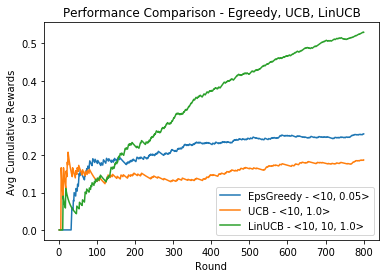

In [11]:
def plot_results(arms, rewards, contexts, T):
    """
    Arguments
    =========
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    T : int
        number of periods that will be plot for tested arm-bandits.
    
    Returns
    =========
    None
    
    """
    
    # Parameter values
    narms = 10
    epsilon = 0.05
    rho = 1.0
    ndims = 10
    alpha = 1.0
    
    # Create the arm-bandits objects
    egreedy = EpsGreedy(narms, epsilon)
    ucb = UCB(narms, rho)
    linUCB = LinUCB(narms, ndims, alpha)
    
    # Offline evaluation of algorithms
    results_EpsGreedy = offlineEvaluate(egreedy, arms, rewards, contexts, T)
    results_UCB = offlineEvaluate(ucb, arms, rewards, contexts, T)
    results_LinUCB = offlineEvaluate(linUCB, arms, rewards, contexts, T)
    
    # Estimate per-round cumulative reward
    prcr_EpsGreedy = []
    prcr_UCB = []
    prcr_LinUCB = [] 
        
    for i in np.arange(T):
        prcr_EpsGreedy.append(np.sum(results_EpsGreedy[:(i+1)]) / (i+1) ) 
        prcr_UCB.append(np.sum(results_UCB[:(i+1)]) / (i+1) )
        prcr_LinUCB.append(np.sum(results_LinUCB[:(i+1)]) / (i+1) )
    
    
    # Set plot configuration variables (title, labels) 
    plt.pyplot.title("Performance Comparison - Egreedy, UCB, LinUCB")
    plt.pyplot.xlabel("Round")
    plt.pyplot.ylabel("Avg Cumulative Rewards")
    
    # Set plot data
    plt.pyplot.plot(np.arange(1,T+1), prcr_EpsGreedy, label='EpsGreedy - <%s, %s>' % (narms, epsilon))
    plt.pyplot.plot(np.arange(1,T+1), prcr_UCB, label='UCB - <%s, %s>' % (narms, rho))
    plt.pyplot.plot(np.arange(1,T+1), prcr_LinUCB, label='LinUCB - <%s, %s, %s>' % (narms, ndims, alpha))
    plt.pyplot.legend(loc='lower right')
    
    plt.pyplot.show()
    
    return None


plot_results(arms, rewards, contexts, 800)

### 4.B.

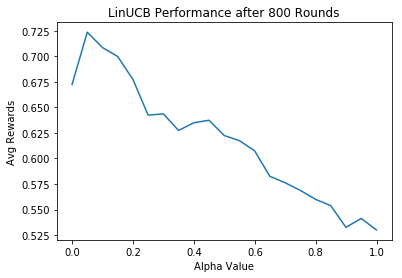

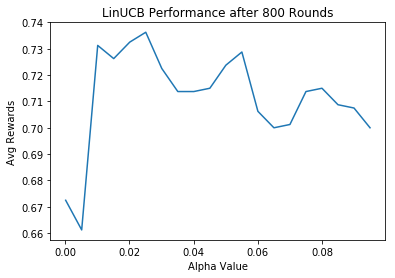

Optimum Alpha Value:	0.73625


In [12]:
def alpha_gridsearch(min_value, max_value, step, nrounds):

    # Set of possible alpha values to evaluate (20 points)
    alpha_set = np.arange(min_value, max_value, step)

    # We store results
    results = []

    for alpha in alpha_set:
        mab = LinUCB(10, 10, alpha)
        results.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, nrounds)))

    # Set plot configuration variables (title, labels) 
    plt.pyplot.title("LinUCB Performance after 800 Rounds")
    plt.pyplot.xlabel("Alpha Value")
    plt.pyplot.ylabel("Avg Rewards")

    # Set plot data
    plt.pyplot.plot(alpha_set, results)
    plt.pyplot.show()
    
    return results, alpha_set


# Define general parameters
nrounds = 800

# Plot 1: General grid search of alpha
min_value = 0.0001
max_value = 1
step = 0.04995

alpha_gridsearch(min_value, max_value, step, nrounds)


# Plot 2: Zoom-in plot
min_value = 0.0001
max_value = 0.1
step = 0.004995

results = alpha_gridsearch(min_value, max_value, step, nrounds)

print ("Optimum Alpha Value:\t%s" % (np.amax(results)))


## 5. KernelUCB

In [13]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [67]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        
        # Validate parameters conditions
        assert narms > 0, "Number of bandits' arms should be greater than 0"
        assert ndims > 0, "Number of dimensions should be greater than 0"
        assert gamma > 0, "Gamma should be a positive number"
        assert eta > 0, "Eta should be a positive number"
        assert np.issubdtype(type(narms), np.integer), "Number of arms must be integer"
        assert np.issubdtype(type(ndims), np.integer), "Number of dimensions must be integer"
        assert np.issubdtype(type(gamma), np.floating), "Gamma must be floating point"
        assert np.issubdtype(type(eta), np.floating), "Eta must be floating point"
        
        
        # Initialize variables
        self.narms = narms
        self.ndims = ndims
        self.kern = kern
        self.gamma = gamma
        self.eta = eta
        self.u_t = np.zeros((1, self.narms))
        self.y_t = []
        self.a_t = []
        
        self.nround = 0
        self.y_t.append(0)
    
    
    def play(self, tround, context):
        
        # Validate parameter conditions
        assert tround > 0, "Number of tround must be greater than 0"
        assert np.issubdtype(type(tround), np.integer), "tround must be integer number"
        assert tround == self.nround + 1, "Can't play round %s. Next round for the arm should be number %s" % (tround, self.nround + 1)
        
        x_t = context.reshape(self.ndims, self.narms)
        
        if tround == 1:
            self.u_t[0,0] = 1
        else:
            for i in np.arange(self.narms):
                x_nt = np.array(x_t[i,:]).reshape(1,-1)
                k_xnt = self.get_historical_kernel( x_nt, self.a_t )
                sigma_nt = np.sqrt( self.kernel(x_nt, x_nt) - k_xnt.T @ self.K_t_rec @ k_xnt )
                self.u_t[0, i] = k_xnt.T @ self.K_t_rec @ self.y_t[:tround-1] + (self.eta * sigma_nt / np.sqrt (self.gamma) )
                
        return self.get_random_argmax(self.u_t)
        
    
    def update(self, arm, reward, context):
        
        # Validate parameter conditions
        assert arm >= 0 and arm <= self.narms, "Arm should be a number between 0 and %s (self.narms parameter)" % (self.narms)
        assert np.issubdtype(type(arm), np.integer), "Arm should be integer"
        assert np.issubdtype(type(reward), np.floating), "Reward should be float"
         
        
        # Get context
        x_t = context.reshape(self.ndims, self.narms)
        x_nt = x_t[arm-1,:].reshape(1,-1)
        
        # Store historical context
        self.a_t.append(x_t[arm-1, :])
        
        # Update reward history
        self.y_t.append(reward)
        
        
        if self.nround == 0:
            self.K_t_rec = 1/(self.kernel(x_nt,x_nt) + self.gamma)
        else:
            b = self.get_historical_kernel( x_nt, self.a_t[:-1] )
            K22 = 1/(self.kernel(x_nt, x_nt) + self.gamma - b.T @ self.K_t_rec @ b)
            K11 = self.K_t_rec + K22 * self.K_t_rec @ b @ b.T @ self.K_t_rec
            K12 = - K22 * self.K_t_rec @ b
            K21 = - K22 * b.T @ self.K_t_rec
            self.K_t_rec = np.vstack((np.hstack((K11, K12)) , np.hstack((K21, K22))))
        
        self.nround +=1
        
        return None
    
        
    def get_random_argmax(self, x):                    # Returns the maximum argument with random choice in case of ties
        argmax = np.where( x == np.amax(x) )
        return (np.random.choice(argmax[0]) + 1)       # Returned arm should a number between 1 and self.narms
    
    
    def kernel(self, x, y):
        psi1_t = self.kern(x)
        psi2_t = self.kern(y)
        return psi1_t.T @ psi2_t
    
    
    def get_historical_kernel(self, x, hist_context):
        
        result = []
        
        for value in hist_context:
            result.append(self.kernel(x,np.array(value).reshape(1,-1)))
            
        return np.array(result).reshape(-1,1)
        

In [ ]:
mab = KernelUCB(10, 10, 2.0, 0.5, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))